# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы. 

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [7]:
!pip install datasets

Импорт необходимых библиотек

In [8]:
import torch
import gc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [11]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать: 

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером. 
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```. 
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [12]:
sentences = []
word_threshold = 32

# Получить отдельные предложения и поместить их в sentences
for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence) if len(word_tokenize(x)) < word_threshold]
    )

  0%|          | 0/25000 [00:00<?, ?it/s]

In [13]:
print("Всего предложений:", len(sentences))

Всего предложений: 198756


Посчитаем для каждого слова его встречаемость.

In [14]:
words = Counter()

# Расчет встречаемости слов
for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

  0%|          | 0/198756 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [15]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

# Наполнение словаря
for word in words.most_common(vocab_size):
    vocab.add(word)

In [16]:
assert '<unk>' in vocab
assert '<bos>' in vocab 
assert '<eos>' in vocab 
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [17]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов). 

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```. 

In [18]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [19]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = []
        # Допишите код здесь
        tokenized_sentence += [self.bos_id] 
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]] 
        tokenized_sentence += [self.eos_id] 

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [20]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [21]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве. 

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации. 
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве. 

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [22]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
    
    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели. 

In [23]:
def train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, num_epoch, eval_steps):
    # Напишите код здесь
    losses = []
    perplexities = []

    for epoch in range(num_epoch):
        torch.cuda.empty_cache()
        gc.collect()
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
    
    return model, np.array(losses), np.array(perplexities)

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её. 

In [24]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, rnn_type: nn, rnn_layers:int=1):
        super().__init__()
        
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = rnn_type(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))
        return projection

In [21]:
rnn_types = [nn.RNN, nn.GRU, nn.LSTM]
losses_rnns = []
perplexities_rnns = []

for rnn_type in rnn_types:
    print(f'Training model with {rnn_type}')
    model = LanguageModel(hidden_dim=128, rnn_type=rnn_type, vocab_size=len(vocab)).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    model, losses, perplexities = train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, 5, len(train_dataloader) // 2)
    losses_rnns.append(losses)
    perplexities_rnns.append(perplexities)

Training epoch 0::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 0::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

(<class 'torch.nn.modules.rnn.RNN'> hidden_dim) Best perplexities: 1.0722 on epoch 1.0
(<class 'torch.nn.modules.rnn.RNN'> hidden_dim) Final perplexities: 1.0724
(<class 'torch.nn.modules.rnn.GRU'> hidden_dim) Best perplexities: 1.0697 on epoch 2.0
(<class 'torch.nn.modules.rnn.GRU'> hidden_dim) Final perplexities: 1.0697
(<class 'torch.nn.modules.rnn.LSTM'> hidden_dim) Best perplexities: 1.0691 on epoch 2.0
(<class 'torch.nn.modules.rnn.LSTM'> hidden_dim) Final perplexities: 1.0691


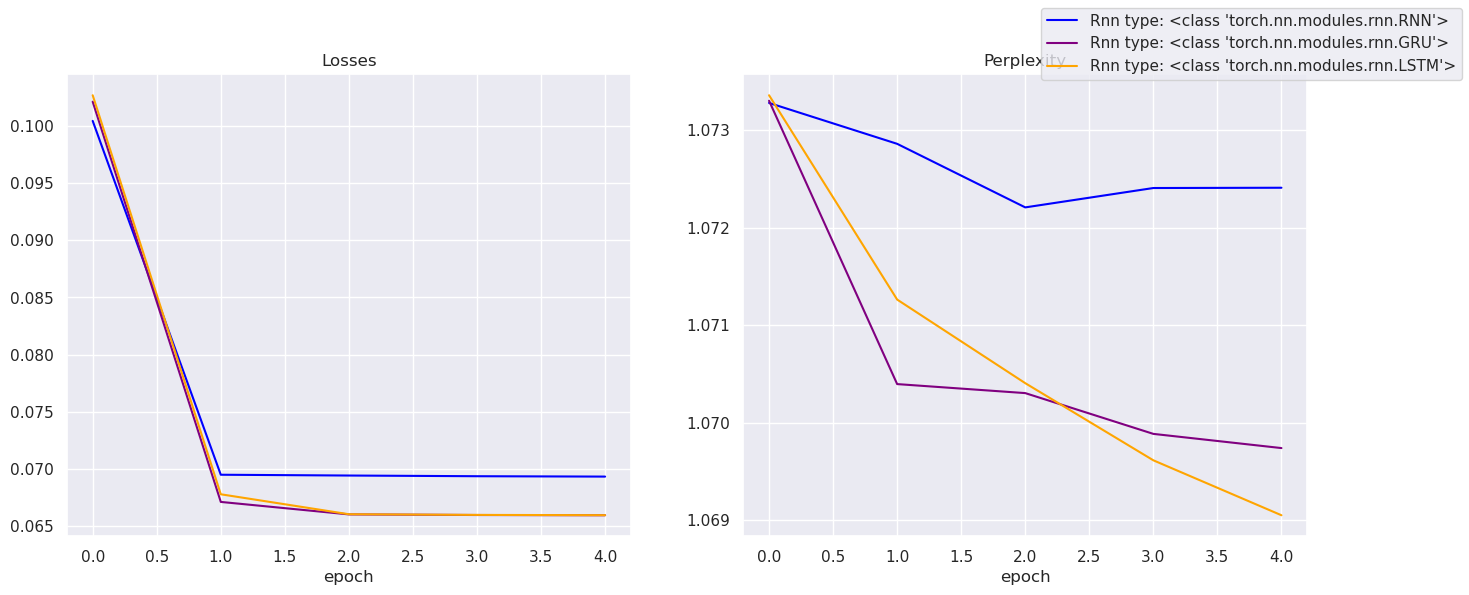

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i, rnn_type, color in zip(range(len(rnn_types)), rnn_types, ['blue', 'purple', 'orange']):
    curr_loss = losses_rnns[i]
    curr_perplexity = perplexities_rnns[i]
    ax[0].plot(np.arange(len(curr_loss)), curr_loss, label=f'{rnn_type}', color=color)
    ax[0].set(title='Losses', xlabel='epoch')
    ax[1].plot(np.arange(len(curr_perplexity)), curr_perplexity, color=color)
    ax[1].set(title='Perplexity', xlabel='epoch')
    print(f'({rnn_type} hidden_dim) Best perplexities: {round(curr_perplexity.min(), 4)} on epoch {curr_perplexity.argmin()/2}')
    print(f'({rnn_type} hidden_dim) Final perplexities: {round(curr_perplexity[-1], 4)}')
fig.legend()
None

### **Вывод**: лучшиe показатели достигаются для модели с **LSTM**

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше. 

### Изменение количества слоев модели

In [26]:
# Проведите второй эксперимент
losses_layers = []
perplexities_layers = []

for rnn_layers in range(1, 4):
    print(f'Training LSTM with {rnn_layers} layers...')
    model = LanguageModel(hidden_dim=128, rnn_type=nn.LSTM, vocab_size=len(vocab), rnn_layers=rnn_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())
    model, losses, perplexities = train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, 5, len(train_dataloader) // 2)
    losses_layers.append(losses)
    perplexities_layers.append(perplexities)

Training LSTM with 1 layers...


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

Training LSTM with 2 layers...


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

Training LSTM with 3 layers...


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

(1 layers) Best perplexity: 1.0677 on epoch 4
(1 layers) Final perplexity: 1.0677
(2 layers) Best perplexity: 1.0677 on epoch 4
(2 layers) Final perplexity: 1.0677
(3 layers) Best perplexity: 1.0677 on epoch 4
(3 layers) Final perplexity: 1.0677


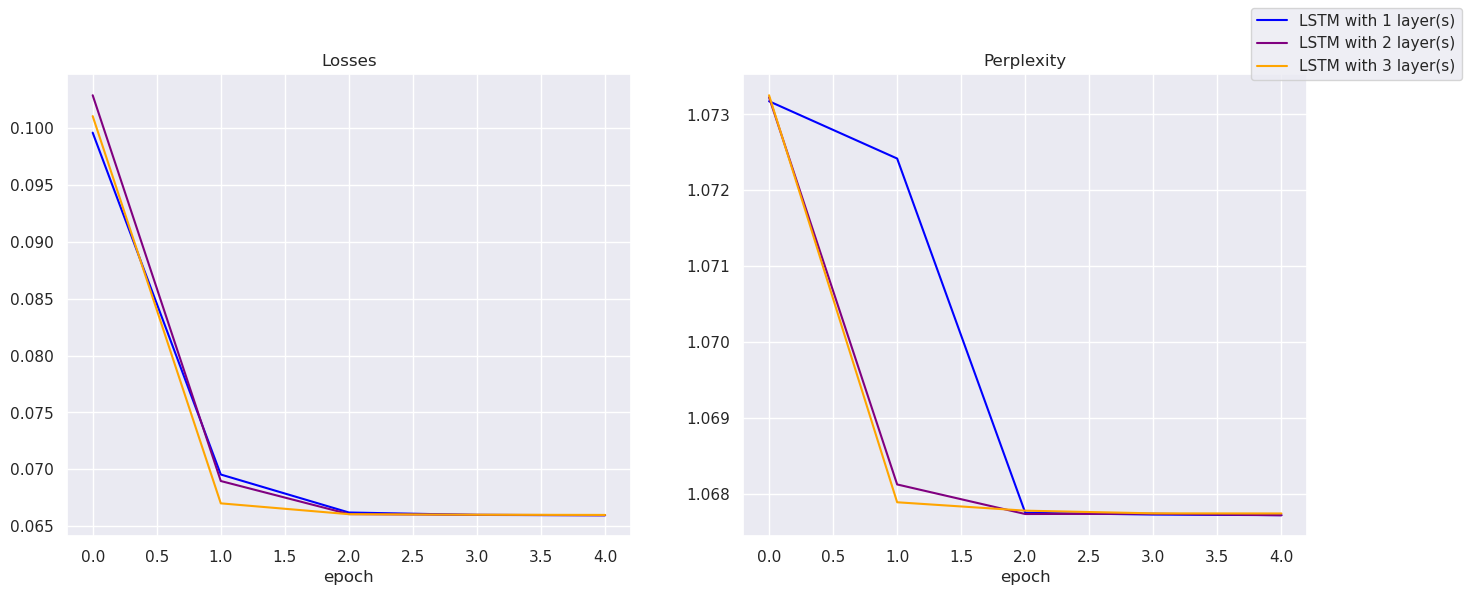

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
for rnn_layers, color in zip(range(1, 4), ['blue', 'purple', 'orange']):
    curr_loss = losses_layers[rnn_layers - 1]
    curr_perplexity = perplexities_layers[rnn_layers - 1]
    ax[0].plot(np.arange(len(curr_loss)), curr_loss, label=f'LSTM with {rnn_layers} layer(s)', color=color)
    ax[0].set(title='Losses', xlabel='epoch')
    ax[1].plot(np.arange(len(curr_perplexity)), curr_perplexity, color=color)
    ax[1].set(title='Perplexity', xlabel='epoch')
    print(f'({rnn_layers} layers) Best perplexity: {round(curr_perplexity.min(), 4)} on epoch {curr_perplexity.argmin()}')
    print(f'({rnn_layers} layers) Final perplexity: {round(curr_perplexity[-1], 4)}')
fig.legend()
None

### **Вывод: увеличение количества слоев никак не повлияло на качество модели**

### Третий эксперимент (Изменение размера скрытого слоя)

In [32]:
hidden_dims = [128, 256, 512]
losses_dims = []
perplexities_dims = []

for hidden_dim in hidden_dims:
    print(f'Training LSTM with {hidden_dim} hidden_dim...')
    model = LanguageModel(hidden_dim=hidden_dim, rnn_type=nn.LSTM, vocab_size=len(vocab)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    model, losses, perplexities = train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, 5, len(train_dataloader) // 2)
    losses_dims.append(losses)
    perplexities_dims.append(perplexities)

Training LSTM with 128 hidden_dim...


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

Training LSTM with 256 hidden_dim...


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

Training LSTM with 512 hidden_dim...


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

(128 hidden_dim) Best perplexity: 1.0332 on epoch 4
(128 hidden_dim) Final perplexity: 1.0332
(256 hidden_dim) Best perplexity: 1.0332 on epoch 4
(256 hidden_dim) Final perplexity: 1.0332
(512 hidden_dim) Best perplexity: 1.0332 on epoch 3
(512 hidden_dim) Final perplexity: 1.0333


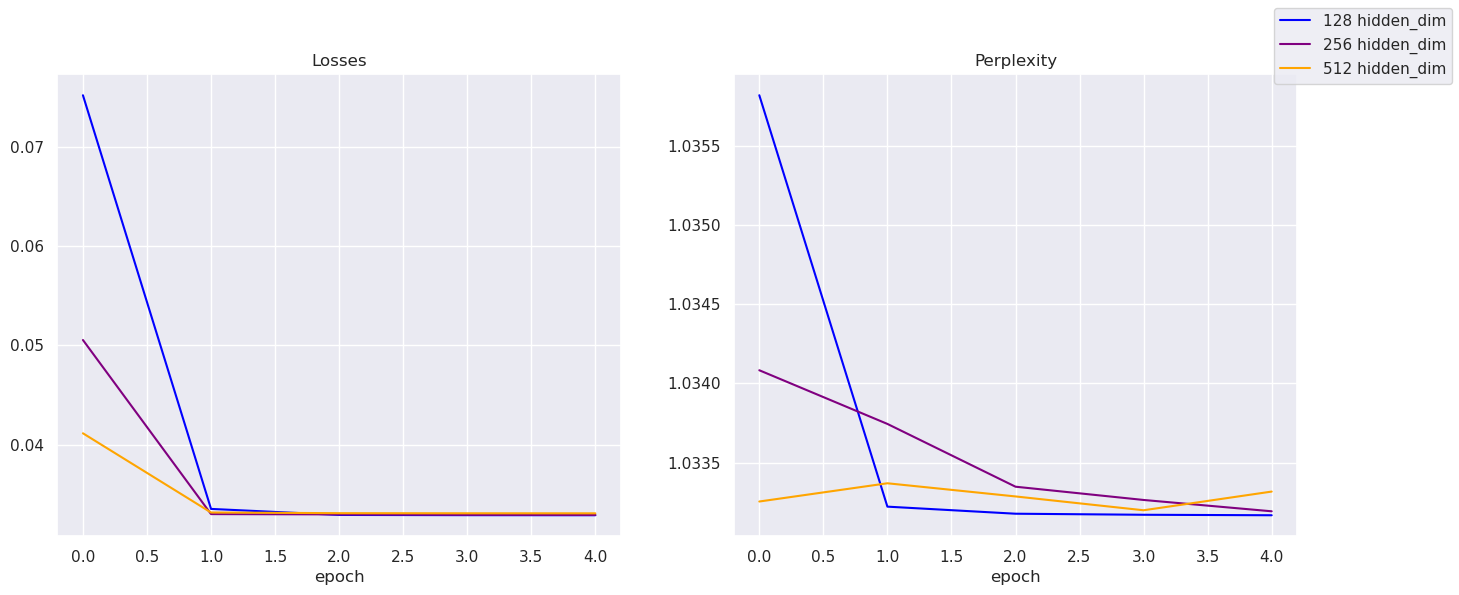

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i, hidden_dim, color in zip(range(len(hidden_dims)), hidden_dims, ['blue', 'purple', 'orange', 'green']):
    curr_loss = losses_dims[i]
    curr_perplexity = perplexities_dims[i]
    ax[0].plot(np.arange(len(curr_loss)), curr_loss, label=f'{hidden_dim} hidden_dim', color=color)
    ax[0].set(title='Losses', xlabel='epoch')
    ax[1].plot(np.arange(len(curr_perplexity)), curr_perplexity, color=color)
    ax[1].set(title='Perplexity', xlabel='epoch')
    print(f'({hidden_dim} hidden_dim) Best perplexity: {round(curr_perplexity.min(), 4)} on epoch {curr_perplexity.argmin()}')
    print(f'({hidden_dim} hidden_dim) Final perplexity: {round(curr_perplexity[-1], 4)}')
fig.legend()
None

### **Вывод: качество модели при увеличении размера скрытого слоя не улучшилось, следовательно стоит оставить исходный размер - 128**

### Четвертый эксперимент (Изменение типа алгоритма оптимизации)

In [46]:
opt_types = [torch.optim.Adam, torch.optim.AdamW, torch.optim.RMSprop]
losses_opts = []
perplexities_opts = []

for opt_type in opt_types:
    print(f'Training model with {opt_type}')
    model = LanguageModel(hidden_dim=128, rnn_type=nn.LSTM, vocab_size=len(vocab)).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = opt_type(model.parameters())
    model, losses, perplexities = train_model(model, train_dataloader, eval_dataloader, criterion, optimizer, 5, len(train_dataloader) // 2)
    losses_opts.append(losses)
    perplexities_opts.append(perplexities)

Training model with <class 'torch.optim.adam.Adam'>


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

Training model with <class 'torch.optim.adamw.AdamW'>


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

Training model with <class 'torch.optim.rmsprop.RMSprop'>


Training epoch 1::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4969 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4969 [00:00<?, ?it/s]

(<class 'torch.optim.adam.Adam'> hidden_dim) Best perplexities: 1.0677 on epoch 4
(<class 'torch.optim.adam.Adam'> hidden_dim) Final perplexities: 1.0677
(<class 'torch.optim.adamw.AdamW'> hidden_dim) Best perplexities: 1.0677 on epoch 3
(<class 'torch.optim.adamw.AdamW'> hidden_dim) Final perplexities: 1.0677
(<class 'torch.optim.rmsprop.RMSprop'> hidden_dim) Best perplexities: 1.0716 on epoch 0
(<class 'torch.optim.rmsprop.RMSprop'> hidden_dim) Final perplexities: 1.074


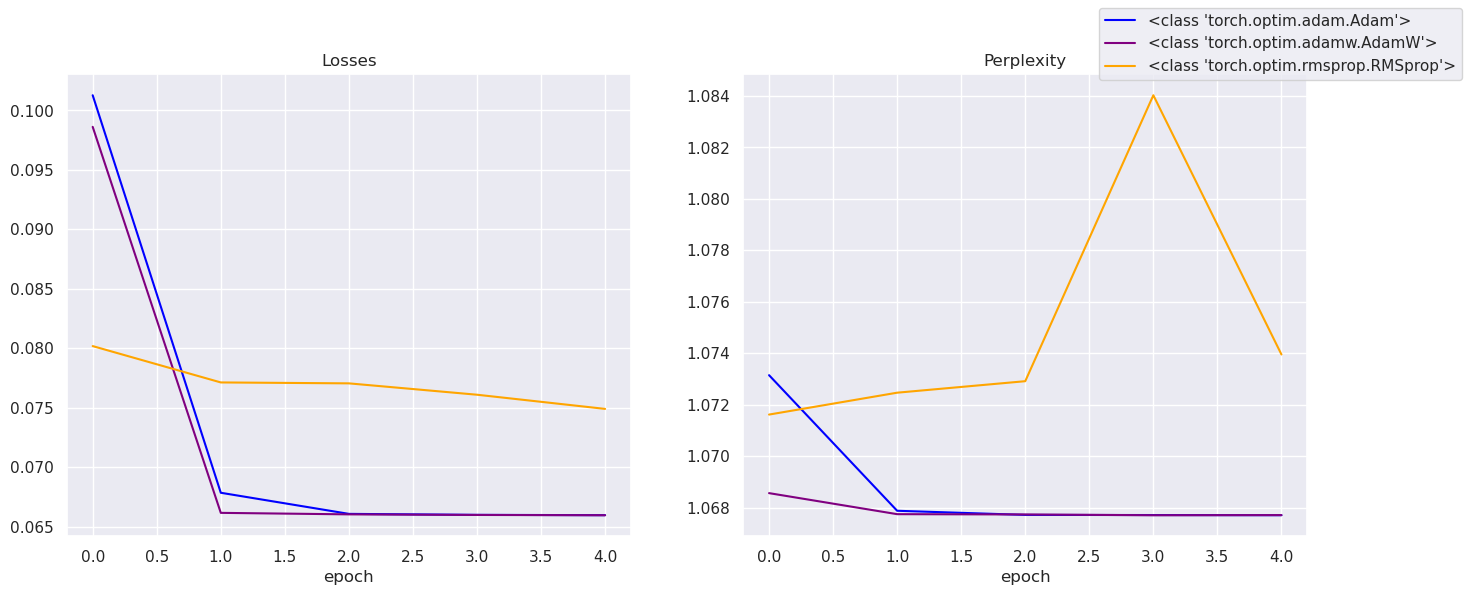

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
for i, opt_type, color in zip(range(len(opt_types)), opt_types, ['blue', 'purple', 'orange']):
    curr_loss = losses_opts[i]
    curr_perplexity = perplexities_opts[i]
    ax[0].plot(np.arange(len(curr_loss)), curr_loss, label=f'{opt_type}', color=color)
    ax[0].set(title='Losses', xlabel='epoch')
    ax[1].plot(np.arange(len(curr_perplexity)), curr_perplexity, color=color)
    ax[1].set(title='Perplexity', xlabel='epoch')
    print(f'({opt_type} hidden_dim) Best perplexities: {round(curr_perplexity.min(), 4)} on epoch {curr_perplexity.argmin()}')
    print(f'({opt_type} hidden_dim) Final perplexities: {round(curr_perplexity[-1], 4)}')
fig.legend()
None

### **Вывод: лучшие показатели достигаются для модели с Adam и AdamW, но для AdamW при меньшем количестве эпох**

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей. 

### Эксперимент 1

Представляет собой подбор архитектуры модели. Для каждого из типов: RNN, LSTM, GRU была построена модель.

In [33]:
rnn_types = [nn.RNN, nn.GRU, nn.LSTM]
perplexities_rnns = []

for rnn_type in tqdm(rnn_types):
    print(f'Testing model with {rnn_type}')
    model = LanguageModel(hidden_dim=128, rnn_type=rnn_type, vocab_size=len(vocab)).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    perplexities = evaluate(model, criterion, test_dataloader)
    perplexities_rnns.append(perplexities)

  0%|          | 0/3 [00:00<?, ?it/s]

Testing model with <class 'torch.nn.modules.rnn.RNN'>
Testing model with <class 'torch.nn.modules.rnn.GRU'>
Testing model with <class 'torch.nn.modules.rnn.LSTM'>


In [35]:
perplexities_rnns

[49894.73434607413, 39098.00362202189, 39892.49755765052]

На тестовом датасете, в отличии от валидационного, лучшего показателя перплексии достигла модель с GRU.

### Эксперимент 2

Поскольку на валидационном датасете лучших показателей достигла LSTM, а на тестовом - GRU, проведем 2 эксперимент для них обоих. 

In [37]:
perplexities_layers = []

for rnn_layers in tqdm(range(1, 4)):
    print(f'Testing LSTM with {rnn_layers} layers...')
    model = LanguageModel(hidden_dim=128, rnn_type=nn.LSTM, vocab_size=len(vocab), rnn_layers=rnn_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    perplexities = evaluate(model, criterion, test_dataloader)
    perplexities_layers.append(perplexities)

  0%|          | 0/3 [00:00<?, ?it/s]

Testing LSTM with 1 layers...
Testing LSTM with 2 layers...
Testing LSTM with 3 layers...


In [38]:
perplexities_layers

[41533.89852427761, 38061.77976723479, 35334.230334181826]

In [39]:
perplexities_layers = []

for rnn_layers in tqdm(range(1, 4)):
    print(f'Testing GRU with {rnn_layers} layers...')
    model = LanguageModel(hidden_dim=128, rnn_type=nn.GRU, vocab_size=len(vocab), rnn_layers=rnn_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    perplexities = evaluate(model, criterion, test_dataloader)
    perplexities_layers.append(perplexities)

Testing GRU with 1 layers...
Testing GRU with 2 layers...
Testing GRU with 3 layers...


In [40]:
perplexities_layers

[33947.43161044148, 51166.71680819382, 40840.84199935608]

Из проведенных экспериментов можно сделать вывод, что модель с RNN-блоком GRU и количеством слоев равным 1 достигает высшего качества по сравнению с другими. 

### Эксперимент 3

Для модели с RNN-блоком GRU и 1 слоем проведем эксперимент с изменением размера скрытого слоя

In [41]:
hidden_dims = [128, 256, 512]
perplexities_dims = []

for hidden_dim in tqdm(hidden_dims):
    print(f'Training GRU with {hidden_dim} hidden_dim...')
    model = LanguageModel(hidden_dim=hidden_dim, rnn_type=nn.GRU, vocab_size=len(vocab)).to(device)
    criterion = nn.CrossEntropyLoss()
    perplexities = evaluate(model, criterion, test_dataloader)
    perplexities_dims.append(perplexities)

  0%|          | 0/3 [00:00<?, ?it/s]

Training GRU with 128 hidden_dim...
Training GRU with 256 hidden_dim...
Training GRU with 512 hidden_dim...


In [42]:
perplexities_dims

[39437.43288066444, 34720.45851401521, 40966.97839866388]

Показатели для размера скрытого слоя 256 оказались наилучшими, что отличает от экспериментов на валидационном датасете.

### Эксперимент 4

Эксперимент представлял собой подбор наилучшего алгоритма оптимизации из следующих: Adam, AdamW, RMSprop. По графикам выше видно что Adam и AdamW справились лучше с данной задачей, но последний сделал это за меньшее количество эпох.